# Living Maps Segmentation

#### Matthew Parker

The aim of this project is to create an open source segmentation alternative to software packages such as ecognition which are currently in use at Natural England.

The features we aimed to include are:

* ability to segment using multiple overlapping raster images taken at different timepoints. This reduces gaps in the output caused by cloud masking of each individual image.
* ability to include a shapefile of existing knowledge of the landscape in the segmentation process, to improve the segments produced.

In [19]:
import sys
import os
import itertools as it
import numpy as np
from matplotlib import pyplot as plt
from skimage import segmentation

# import segmentation functions
import rio_segment as rseg

# get rid of noisy rio_segment logging
stdout = sys.stdout
sys.stdout = open(os.devnull, 'w')

## Edge detection

Here we are using two S2 satellite images of a small example region of Devon. The first raster in the list is used as a template, all following rasters are clipped to the extent of this template and resized so that the resulting arrays have the same dimensions.

As the segmentation method we are using (watershedding) only accepts a single channel image as input, the function uses the sobel method to detect edges in the image. The layers are then merged, taking the maximum pixel intensity for each position.

We are also including a shapefile of known land use information, including field boundaries. The edges from these shapes are rasterized into an array of the same shape as the template raster, and included as layers when computing the max pixel intensity. The weight of this information over the spectral data can be altered using the shp_weight parameter - it can be set between zero (no effect) and 255.

In [2]:
rasters = [
    'D:\\Living Maps\\S2\\_S2_NDevonDart_Masked\\NDevonDart_S2_20160719_37_5_mask_clipped.tif',
    'D:\\Living Maps\\S2\\_S2_NDevonDart_Masked\\NDevonDart_S20161106_37_5_mask_clipped.tif'
]

shapes = [
    'D:\\Living Maps\\LPIS\\North_Devon_LPIS.shp'
]

edges, mask, t, c = rseg.edges_from_raster_and_shp(
    rasters, shapes, shp_weight=180, fill_holes=True, perc=(0, 98), no_data=0
)

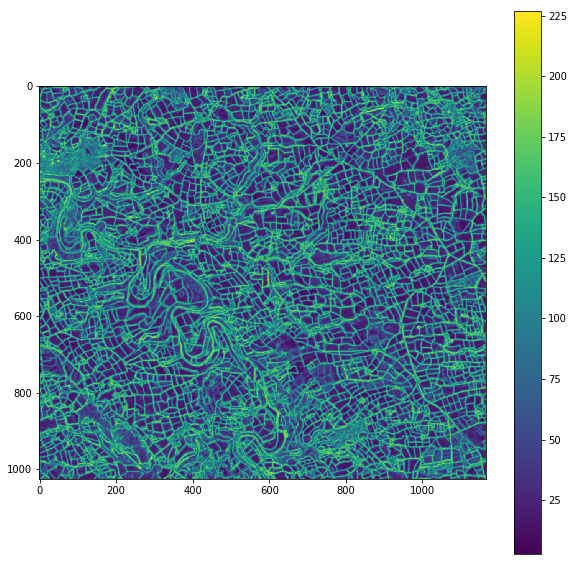

In [3]:
fig, ax = plt.subplots(figsize=(10, 10))
img = ax.imshow(edges)
plt.colorbar(img)
plt.show()

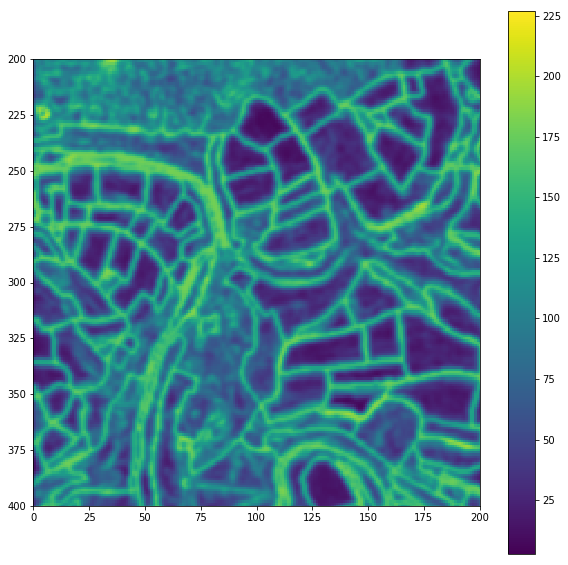

In [4]:
# zoomed in view of river, bit of urban and some arable
fig, ax = plt.subplots(figsize=(10, 10))
img = ax.imshow(edges)
plt.colorbar(img)
ax.set_xlim(0, 200)
ax.set_ylim(400, 200)
plt.show()

## Watershed segmentation

The approach we are using to initially segment the image is watershed. The `watershed_segment` function produces seeds in local minima of the edge map, then grows these into segments using watershedding. Adjusting the footprint size of the seed production will alter the number of segments produced - the smaller the footprint, the more segments that are produced. Setting to one will produce the max possible number of segments.

In [5]:
labels = rseg.watershed_segment(edges, footprint_size=3)
marked_labels = segmentation.find_boundaries(labels)

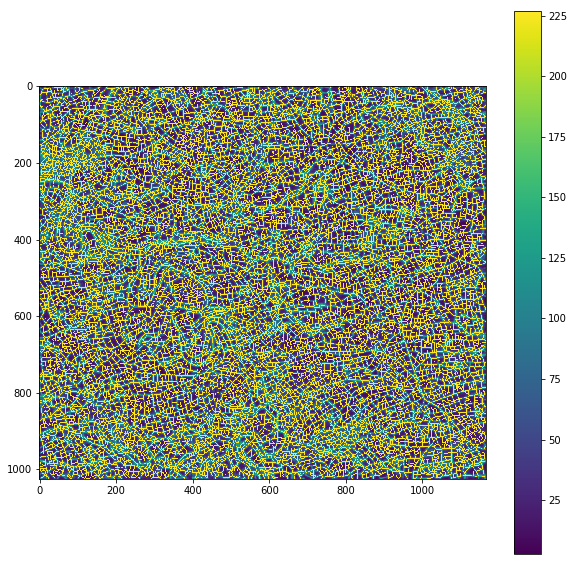

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(np.maximum(marked_labels*255, edges))
plt.colorbar(img)
plt.show()

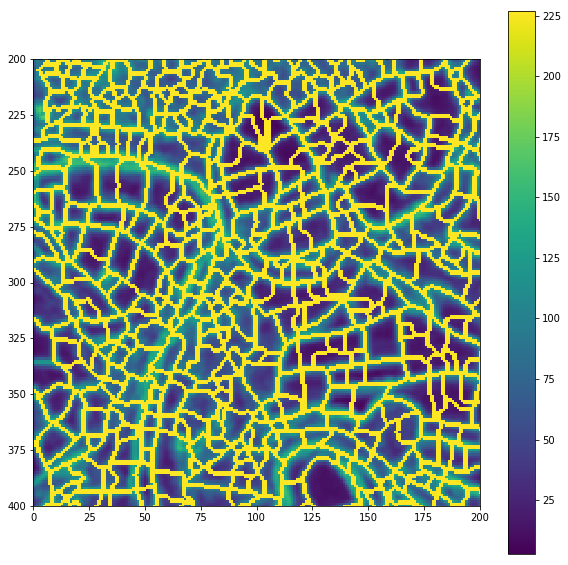

In [7]:
# zoomed in view of river, bit of urban and some arable
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(np.maximum(marked_labels*255, edges))
plt.colorbar(img)
ax.set_xlim(0, 200)
ax.set_ylim(400, 200)
plt.show()

## Merging adjacent segments using a Region Adjacency Graph

Using a small footprint results in a wildly oversegmented image, however it is a good way of making sure we capture all the "real" edges and all small features. We can then merge adjacent segments which are very similar using a graph based approach (region adjacency graph, or RAG) to produce a set of segments which represent the features of the image much better.

The edges of the RAG are weighted using the mean pixel intensity of the boundary between the two segments in the edge map. We can also apply a size penalty to the edges based on the size in pixels in the two segments, to prevent any merges getting too big. The `size_pen` parameter can be used to increase or decrease the strength of this behaviour, set to zero to turn off.

Once the RAG has been created, the threshold percentile for merging is calculated from the distribution of edge weights, from the `threshold` parameter (a percentile). Nodes of the graph (and their corresponding segments) are repeatedly merged under there are no longer any edge weights below this value.

In [8]:
refined_labels = rseg.rag_merge_threshold(edges, labels,
                                          threshold=40,
                                          size_pen=10)
marked_refined_labels = segmentation.find_boundaries(refined_labels)

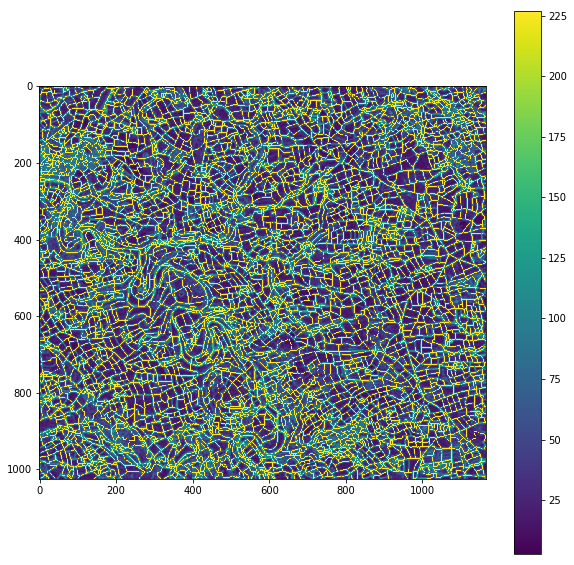

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(np.maximum(marked_refined_labels*255, edges))
plt.colorbar(img)
plt.show()

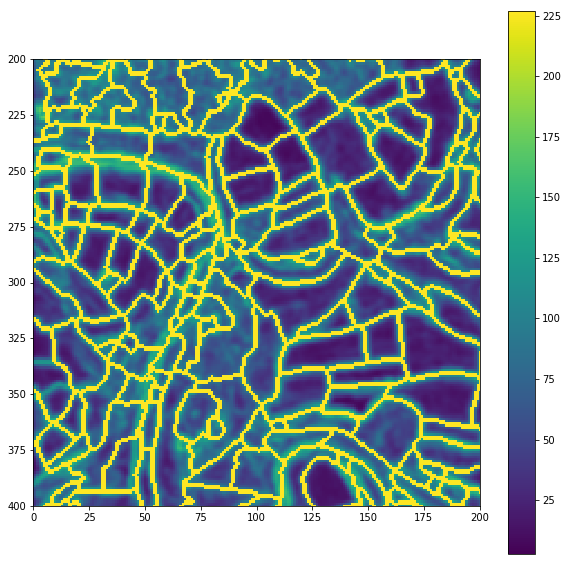

In [10]:
# zoomed in view of river, bit of urban and some arable
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(np.maximum(marked_refined_labels*255, edges))
plt.colorbar(img)
ax.set_xlim(0, 200)
ax.set_ylim(400, 200)
plt.show()

# Parameter testing

## Varying shapefile weighting

In [47]:
edgemaps = []
initlabels = []
refinedlabs = []
for shp_weight in (0, 100, 180, 255):
    e, *_ = rseg.edges_from_raster_and_shp(
        rasters, shapes, shp_weight=shp_weight,
        fill_holes=True, perc=(0, 98), no_data=0
    )
    edgemaps.append(e)

    labels = rseg.watershed_segment(e, footprint_size=2)
    marked_labels = segmentation.find_boundaries(labels)
    initlabels.append(marked_labels)

    refined_labels = rseg.rag_merge_threshold(e, labels,
                                              threshold=40,
                                              size_pen=10)
    marked_refined_labels = segmentation.find_boundaries(refined_labels)
    refinedlabs.append(marked_refined_labels)

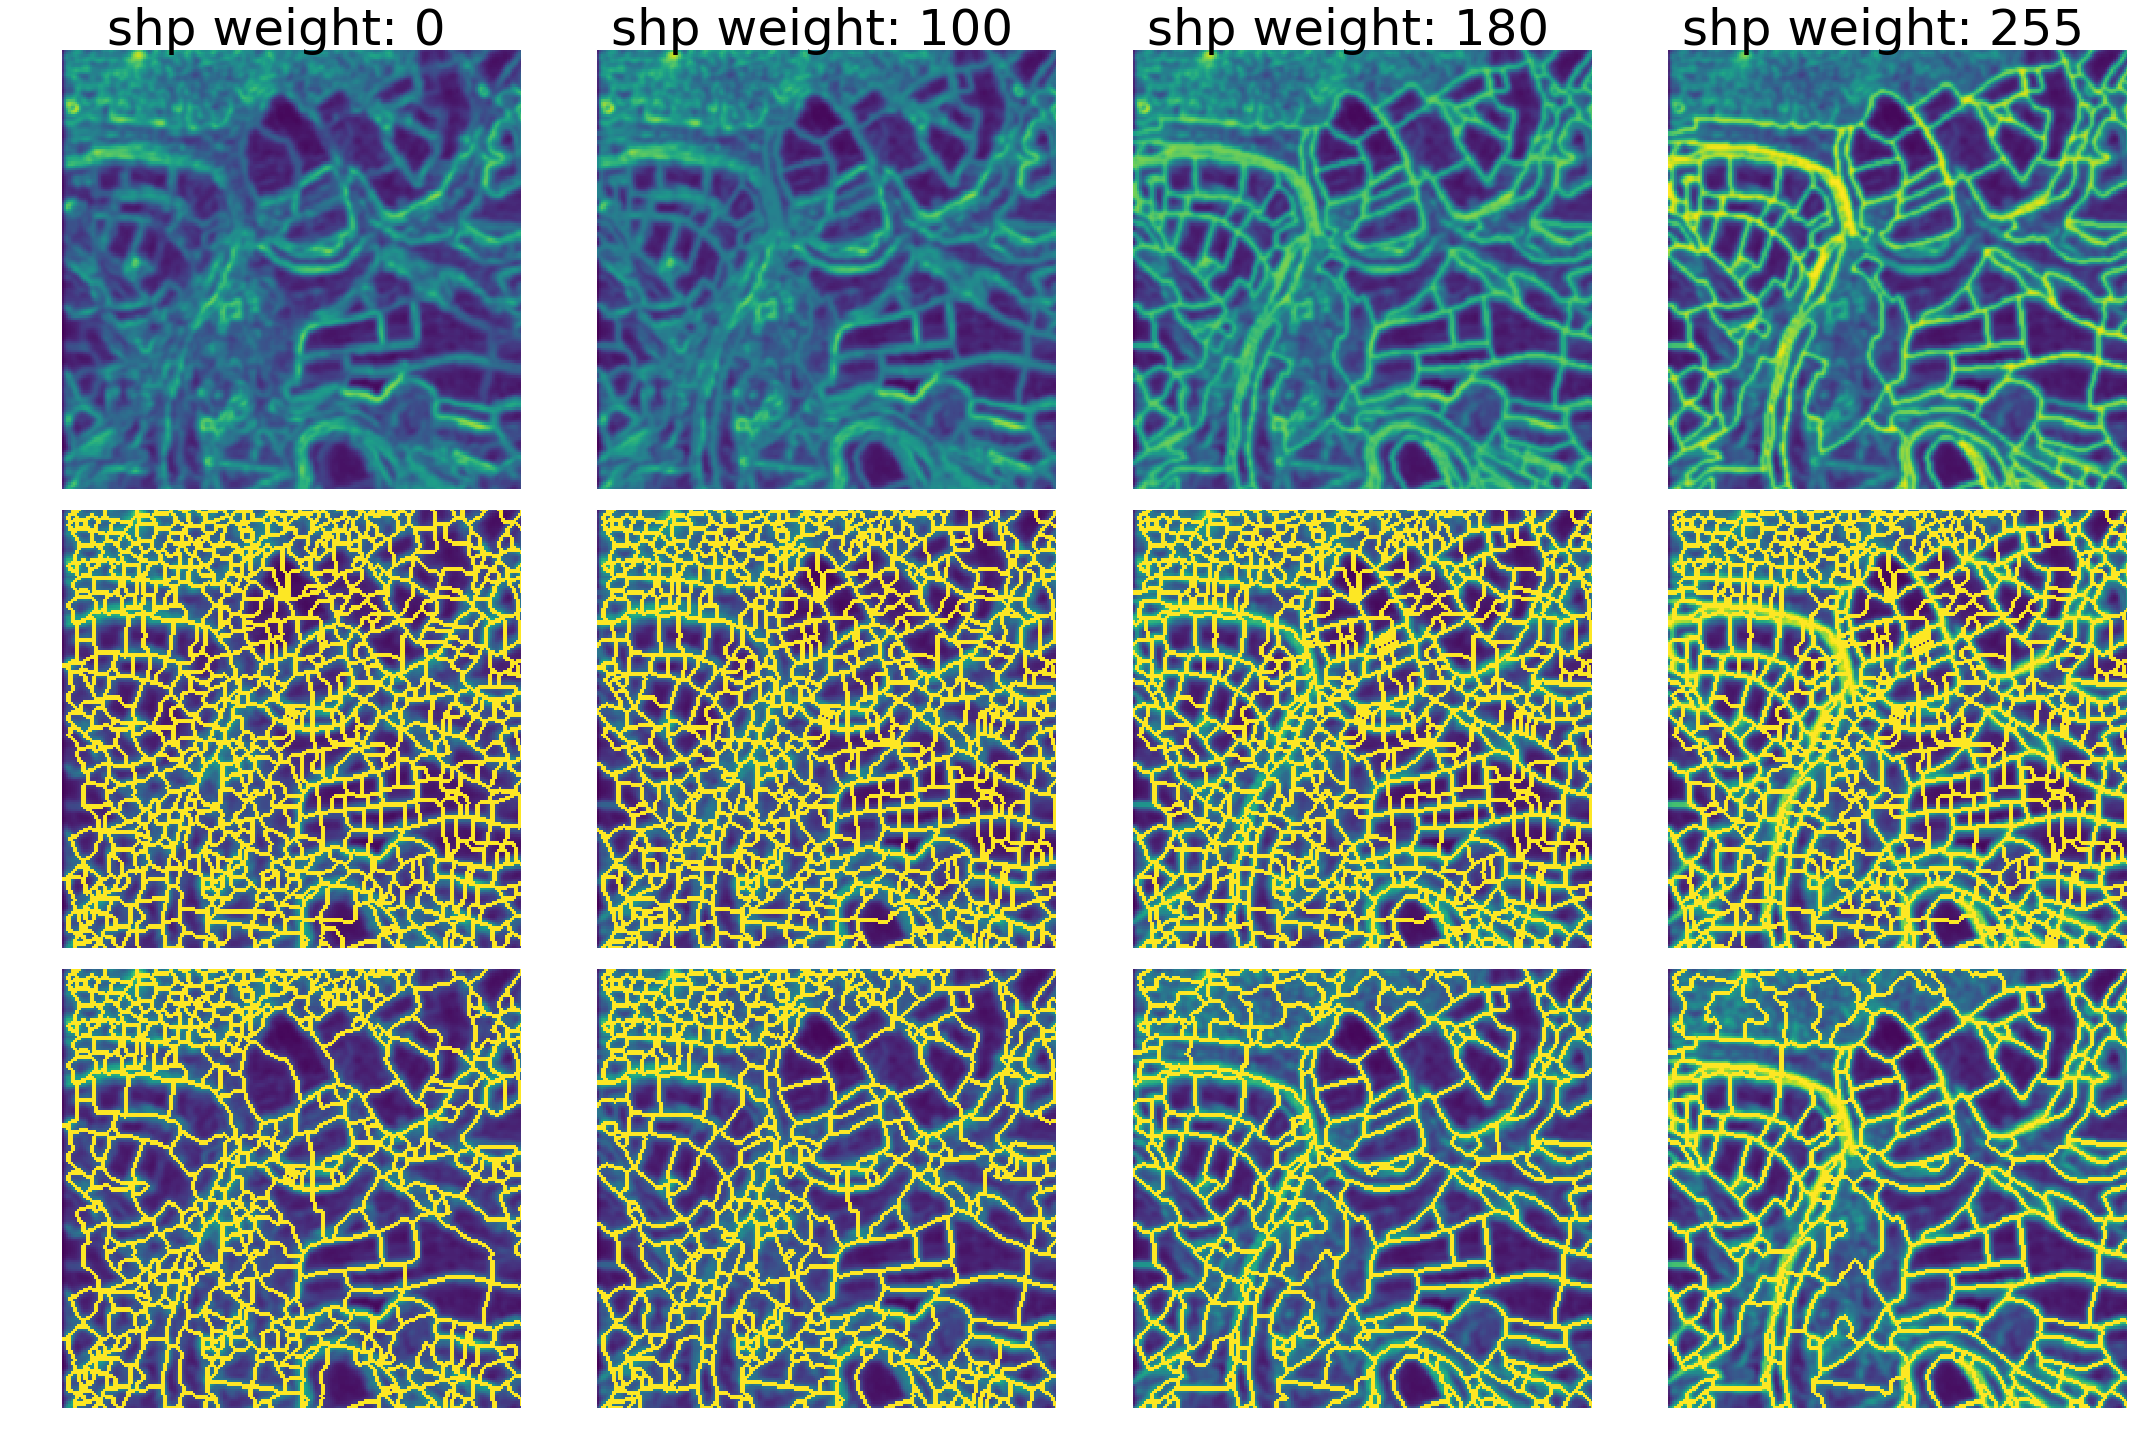

In [48]:
fig, axes = plt.subplots(figsize=(30, 20), ncols=4, nrows=3,
                         sharey=True, sharex=True)
titles = (
    'shp weight: 0',
    'shp weight: 100',
    'shp weight: 180',
    'shp weight: 255',
)

for title, col, edges, labs, reflabs in zip(titles, axes.T, edgemaps,
                                            initlabels, refinedlabs):
    col[0].imshow(edges)
    col[0].set_title(title, size=50)
    col[1].imshow(np.maximum(labs*255, edges))
    col[2].imshow(np.maximum(reflabs*255, edges))
    col[0].set_axis_off()
    col[1].set_axis_off()
    col[2].set_axis_off()


axes[0][0].set_xlim(0, 200)
axes[0][0].set_ylim(400, 200)
plt.tight_layout()
plt.show()

Including the shapefile, even at a low weighting, appears to slightly improve initial segmentation. It also seems increase the number of segments that get merged, presumably because more edges have very high weightings, driving up the value of the threshold percentile. A weighting of 100 - 150 may be optimal, as we do not want to just recapitulate the shapefile edges.

## Varying footprint size for segmentation

In [41]:
initlabels = []
refinedlabs = []

e, *_ = rseg.edges_from_raster_and_shp(
    rasters, shapes, shp_weight=150,
    fill_holes=True, perc=(0, 98), no_data=0
)

for footprint in (1, 2, 3, 4):
    labels = rseg.watershed_segment(e, footprint_size=footprint)
    marked_labels = segmentation.find_boundaries(labels)
    initlabels.append(marked_labels)

    refined_labels = rseg.rag_merge_threshold(e, labels,
                                              threshold=40,
                                              size_pen=10)
    marked_refined_labels = segmentation.find_boundaries(refined_labels)
    refinedlabs.append(marked_refined_labels)

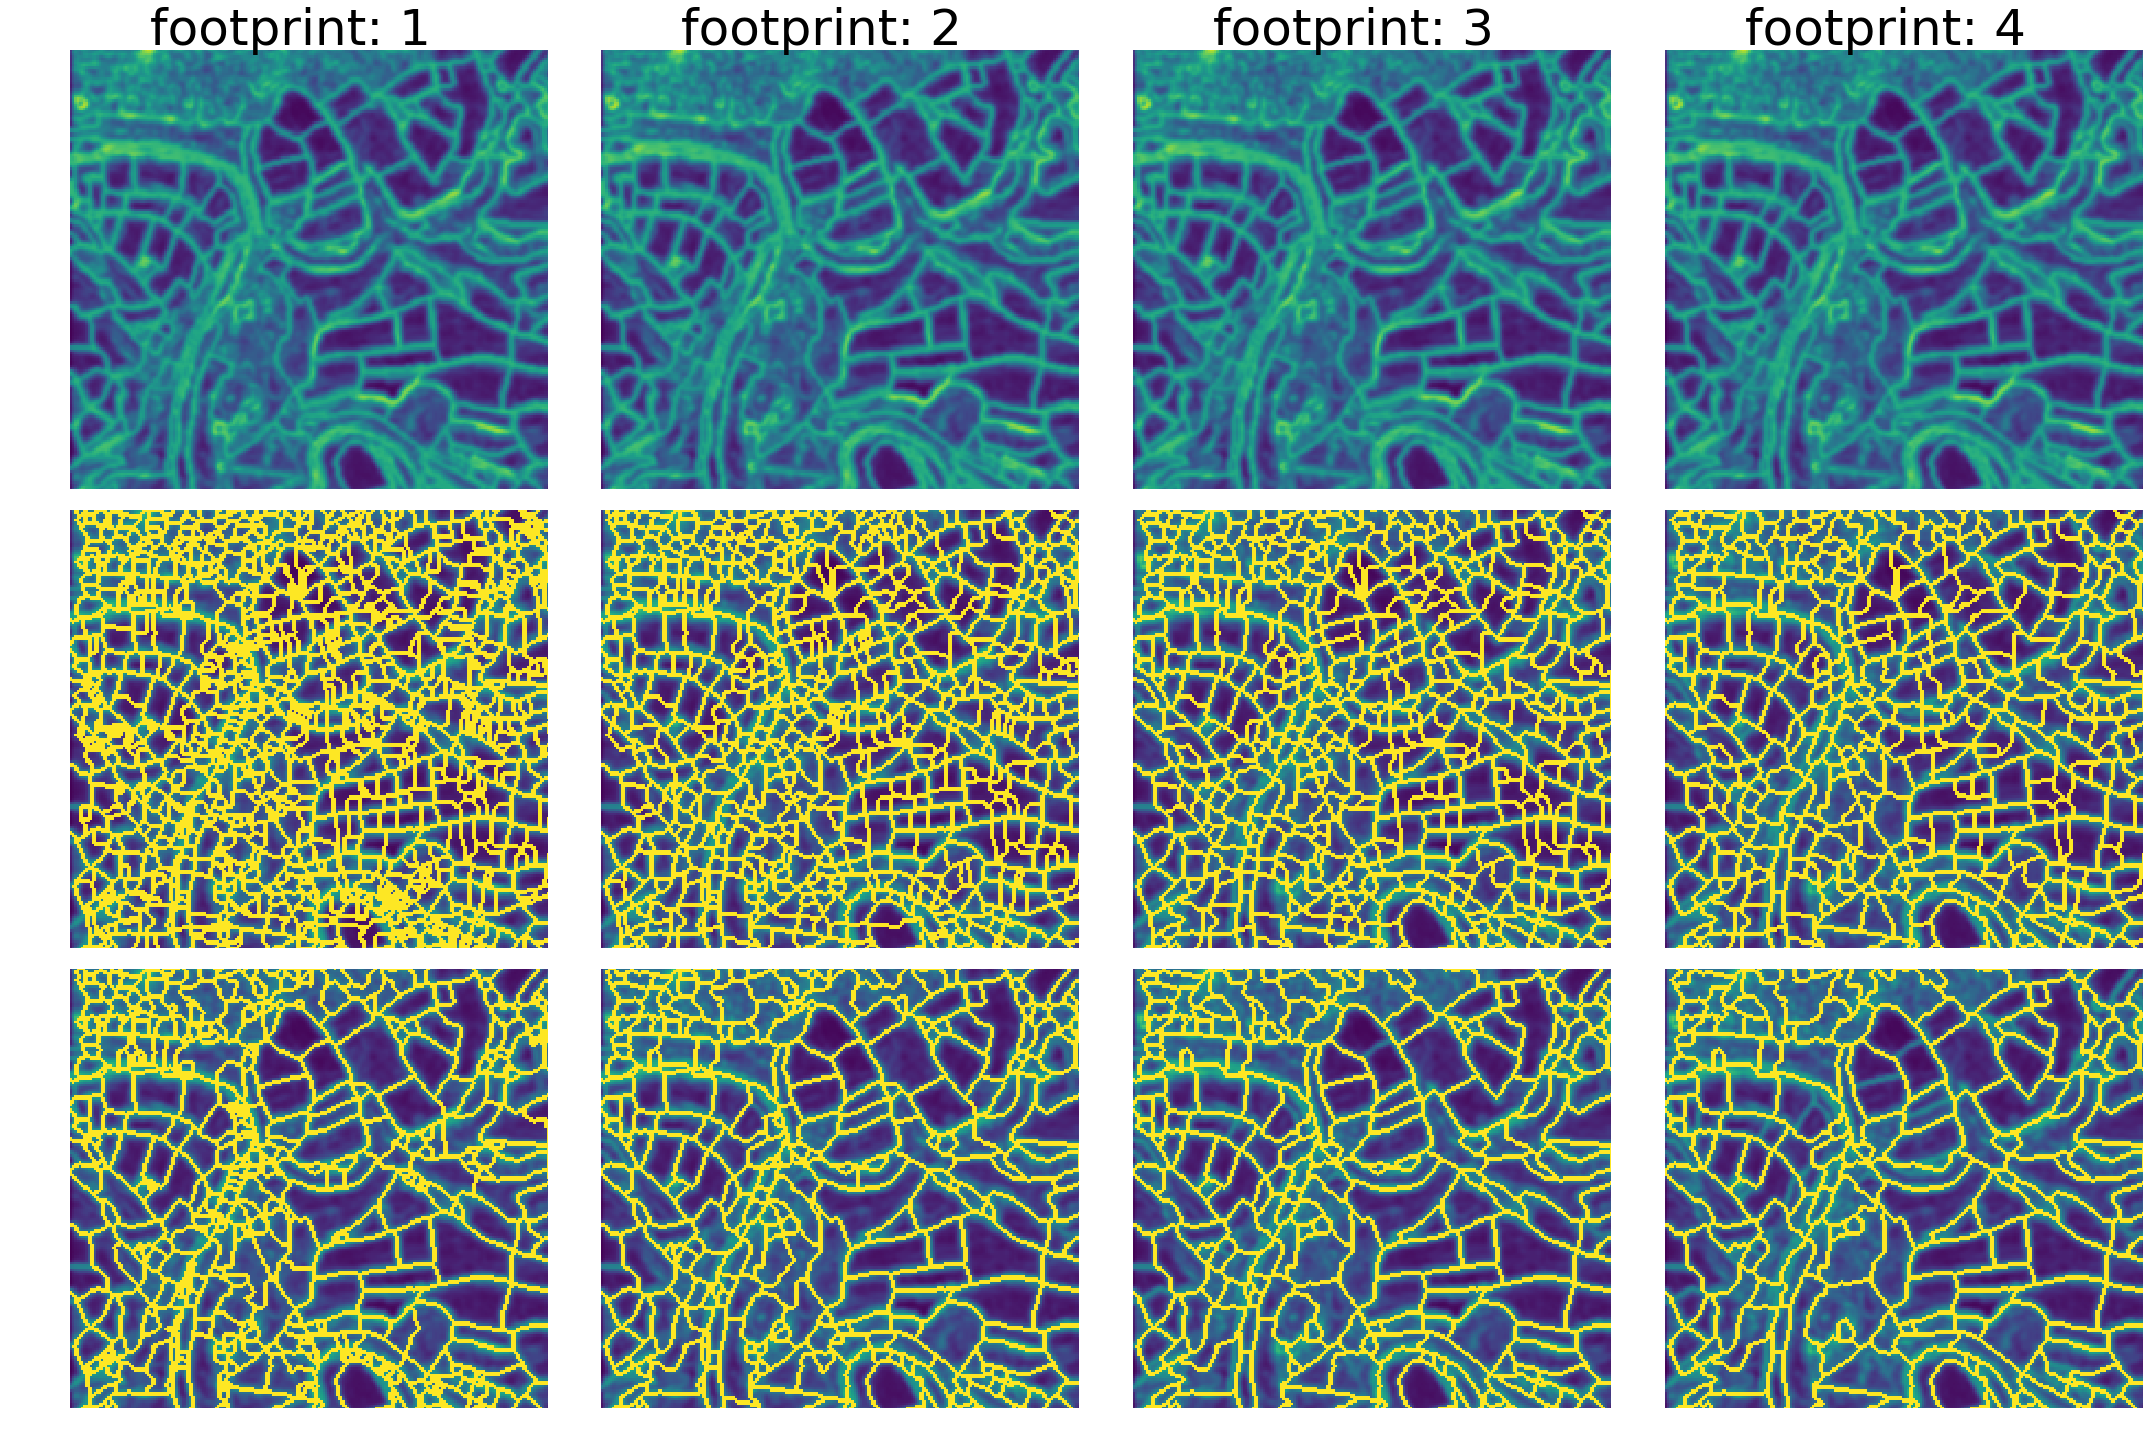

In [42]:
fig, axes = plt.subplots(figsize=(30, 20), ncols=4, nrows=3,
                         sharey=True, sharex=True)
titles = (
    'footprint: 1',
    'footprint: 2',
    'footprint: 3',
    'footprint: 4'
)

for title, col, edges, labs, reflabs in zip(titles, axes.T, edgemaps,
                                            initlabels, refinedlabs):
    col[0].imshow(edges)
    col[0].set_title(title, size=50)
    col[1].imshow(np.maximum(labs*255, edges))
    col[2].imshow(np.maximum(reflabs*255, edges))
    col[0].set_axis_off()
    col[1].set_axis_off()
    col[2].set_axis_off()

axes[0][0].set_xlim(0, 200)
axes[0][0].set_ylim(400, 200)
fig.suptitle('Varying footprint size')
plt.tight_layout()
plt.show()

While it's probable that using a larger footprint of 3 might miss some very small features, it also does not oversegment nearly as much. If we did use a smaller footprint, we could try to correct for this by increasing the merge threshold and reducing the size penalty when merging.

## Covarying threshold percentile and size penalty

In [40]:
thresholds = (10, 25, 40, 75)
size_pens = (0, 5, 10, 25)
refinedlabs = []

e, *_ = rseg.edges_from_raster_and_shp(
    rasters, shapes, shp_weight=150,
    fill_holes=True, perc=(0, 98), no_data=0
)

labels = rseg.watershed_segment(edges, footprint_size=2)
marked_labels = segmentation.find_boundaries(labels)

for t, sp in it.product(thresholds, size_pens):
    refined_labels = rseg.rag_merge_threshold(e, labels,
                                              threshold=t,
                                              size_pen=sp)
    marked_refined_labels = segmentation.find_boundaries(refined_labels)
    refinedlabs.append(marked_refined_labels)

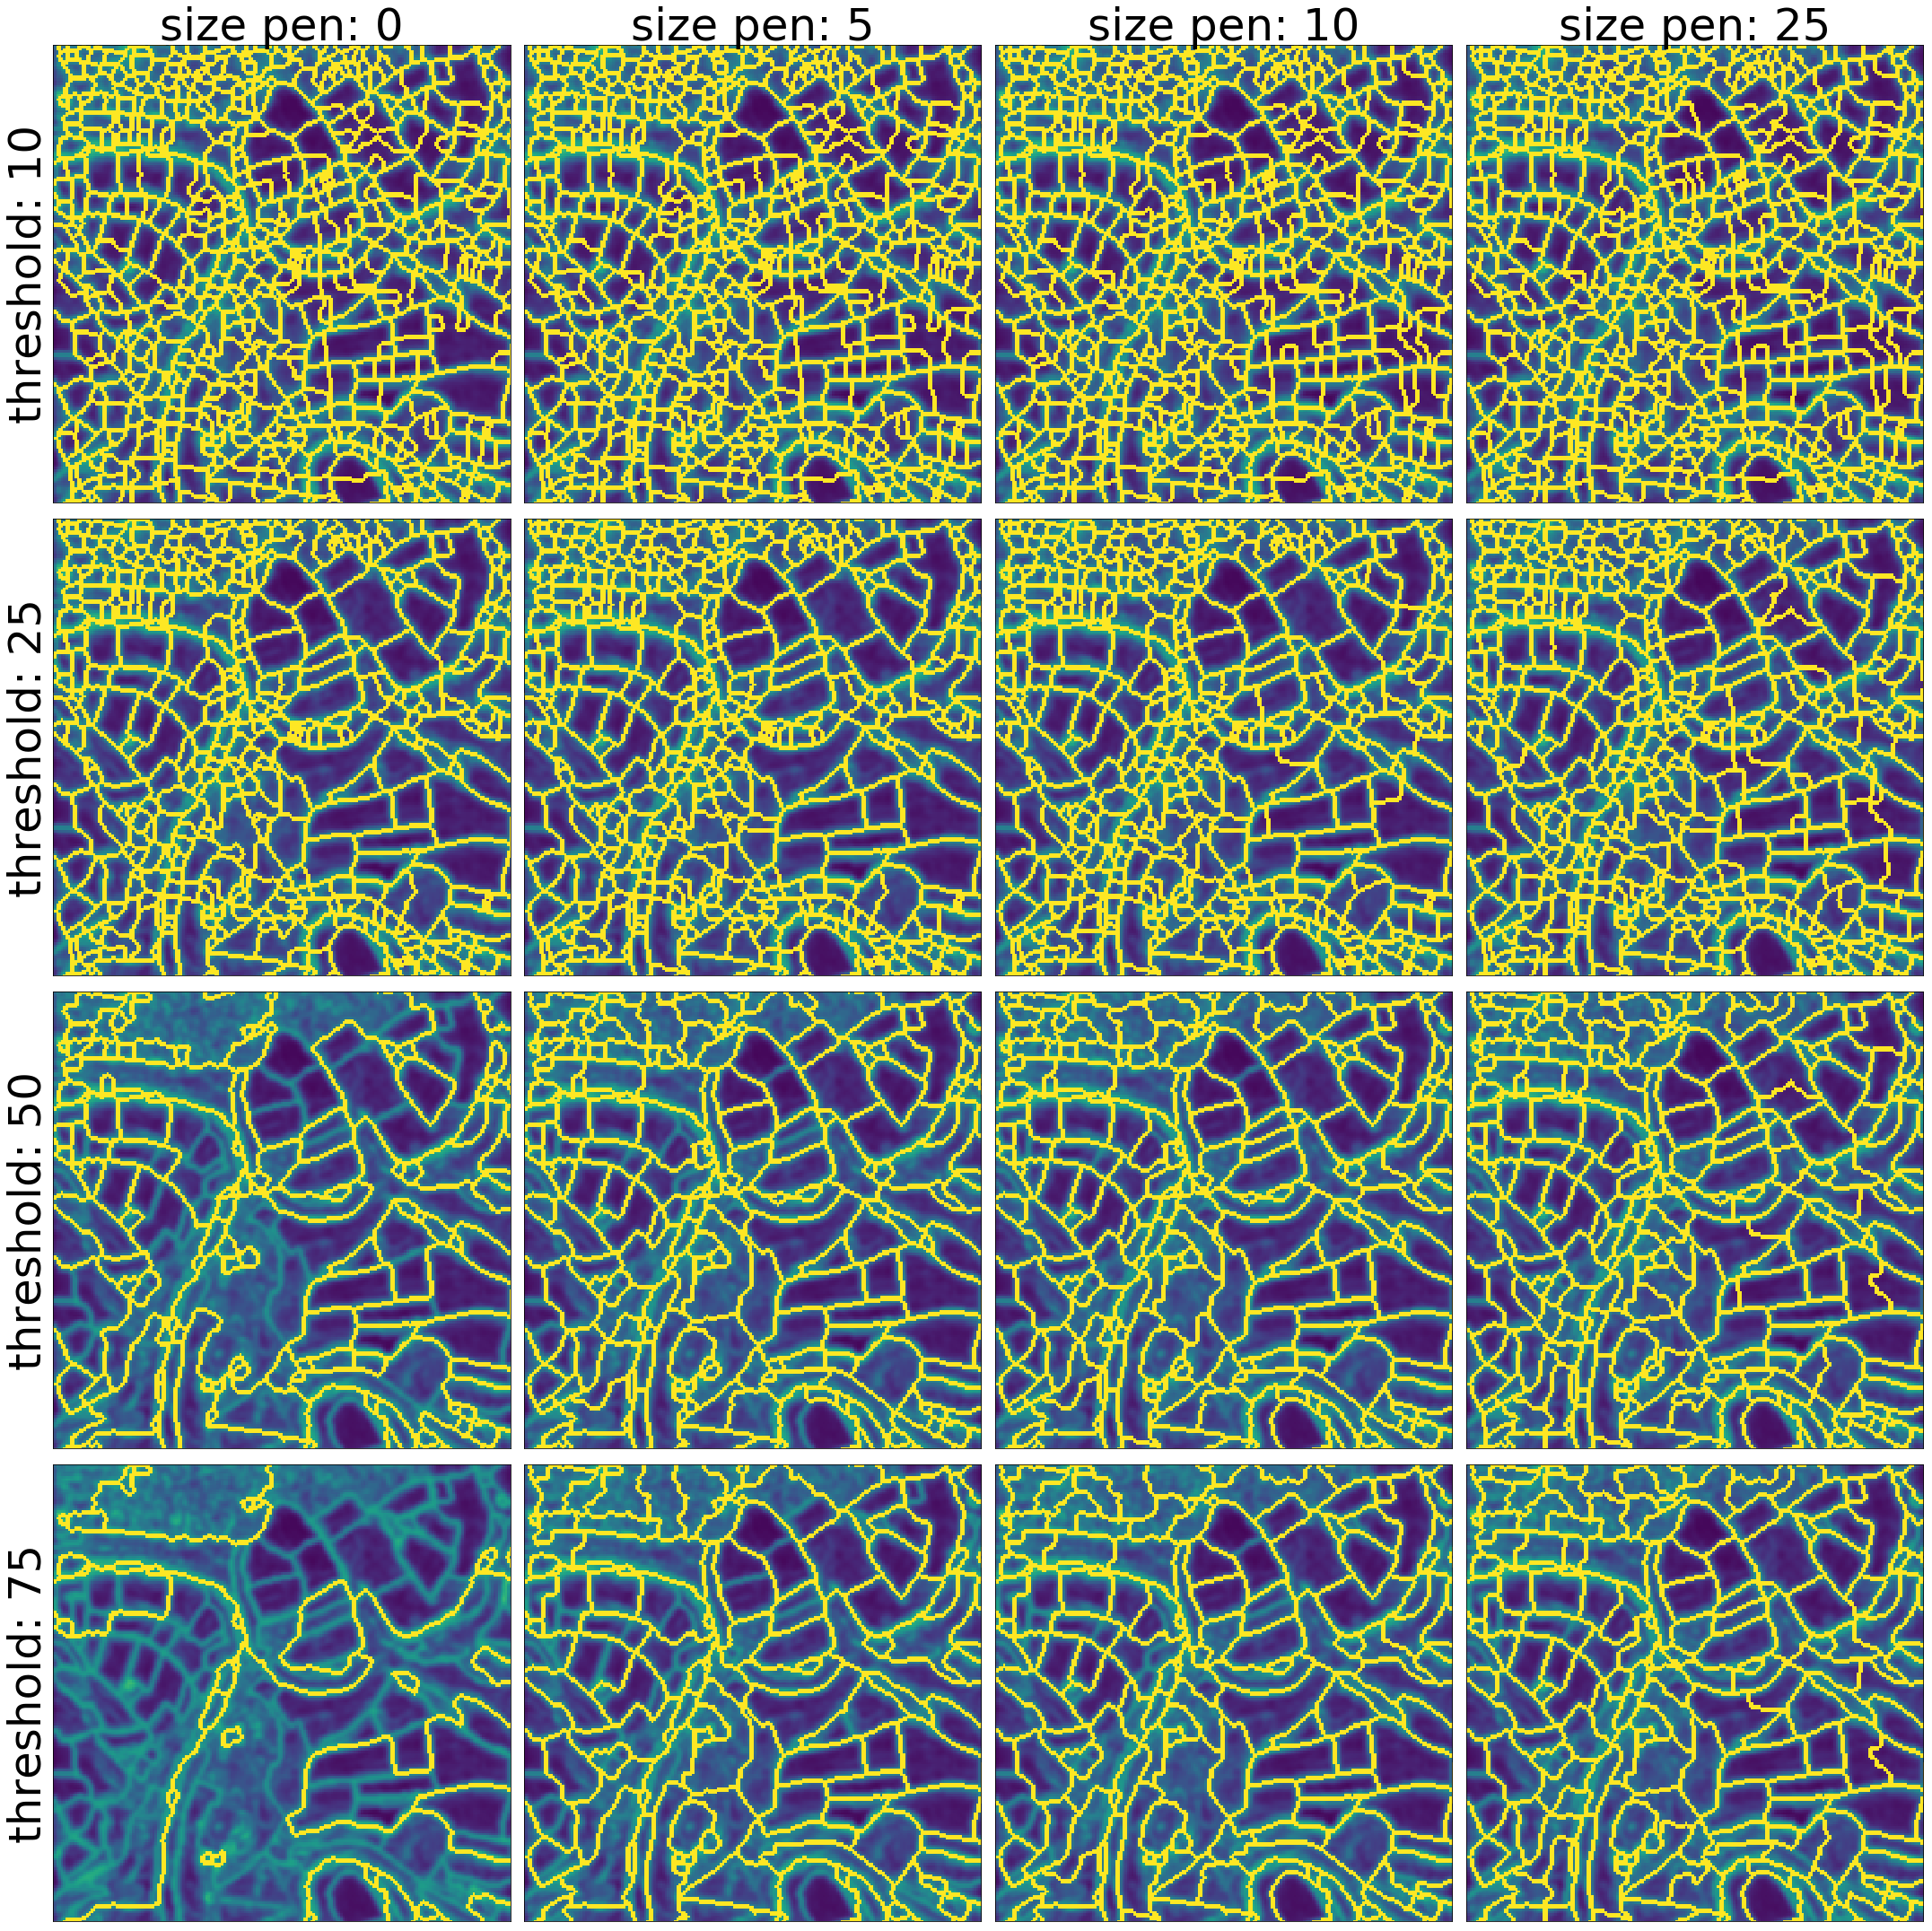

In [39]:
fig, axes = plt.subplots(figsize=(30, 30), ncols=4, nrows=4)

for ax, labs in zip(axes.ravel(), refinedlabs):
    ax.imshow(np.maximum(labs*255, e))
    ax.set_xlim(0, 200)
    ax.set_ylim(400, 200)
    ax.set_xticks([])
    ax.set_yticks([])

for first_in_row, t in zip(axes[:, 0], thresholds):
    first_in_row.set_ylabel('threshold: {}'.format(t), size=50)

for first_in_col, sp in zip(axes[0], size_pens):
    first_in_col.set_title('size pen: {}'.format(sp), size=50)

fig.suptitle('')')
plt.tight_layout()
plt.show()